In [1]:
import numpy as np
import math
from qiskit import *
from qiskit.pulse import *
from qiskit.test.mock import *
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.compiler import assemble
from qiskit.pulse import DriveChannel
from qiskit.pulse import Acquire, AcquireChannel, MemorySlot

In [106]:
print("All Fake backends that support Open Pulse: \n")
from qiskit.test import mock as backend_mocks
for fake in dir(backend_mocks.backends):
    if 'Fake' in fake:
        backend = getattr(backend_mocks.backends,fake)()
        if hasattr(backend,'defaults'):
            if backend.configuration().open_pulse:
                print(fake, backend.configuration().n_qubits)

All Fake backends that support Open Pulse: 

FakeAlmaden 20
FakeArmonk 1
FakeAthens 5
FakeBelem 5
FakeBoeblingen 20
FakeCasablanca 7
FakeJohannesburg 20
FakeLima 5
FakeManhattan 65
FakeMontreal 27
FakeMumbai 27
FakeParis 27
FakeQuito 5
FakeSingapore 20
FakeSydney 27
FakeToronto 27
FakeValencia 5


In [117]:
def hadamard(backend, qubit):
    """
    Returns pulse for applying a hadamard gate calibrated for a specific backend to a specific qubit
    """
    qc = QuantumCircuit(1,1)

def fmeasure(bases, sched, backend):
    """
    Measures each qubit of the device (fake) backend according to the dict bases, which has the form
        bases = {1: 'Z', 2: 'X', 5: 'Y', ...}
    where any qubits not explicitly measured in the dict will only receive aqcuire instructions
    The input schedule "sched" will be returned unchanged, except with measurement pulses appended where desired,
    and acquire pulses appended synchronously on ALL qubits
    """
    config = backend.configuration()
    N = config.n_qubits
    assert(len(bases)<=N)
    
    
#     with pulse.build(backend) as meas_sched:
#         for iq in bases:
#             if bases[iq]=='X':
#                 pulse.h(iq)
#             if bases[iq]=='Y':
#                 qc.sdg(iq)
#                 qc.h(iq)
#             if bases[iq]=='Z':
#                 qc.id(iq)

    # CONVERT ABSTRACT CIRCUIT            
    qc = QuantumCircuit(N, N)
    for iq in bases:
        if bases[iq]=='X':
            qc.h(iq)
        if bases[iq]=='Y':
            qc.sdg(iq)
            qc.h(iq)
#         if bases[iq]=='Z':
#             qc.id(iq)
#     for iq in bases:
#         qc.measure(iq,iq)
    for iq in range(N):
        qc.measure(iq,iq)
    qc = transpile(qc, backend)
    measurements = qiskit.schedule(qc, backend)    

    new_sched = sched.append(measurements)
#     new_sched += measurements << new_sched.duration
#     new_sched += pulse.acquire(1200, pulse.acquire_channel(0), MemorySlot(0))

#     measure.exclude(channels=[pulse.MeasureChannel(i) for i in range(1, n_qubits)])
    return qc, new_sched

In [129]:
backend = qiskit.test.mock.FakeValencia()
# backend = qiskit.test.mock.FakeAlmaden()
# backend = qiskit.test.mock.FakeArmonk()

config = backend.configuration()
defaults = backend.defaults()
dc = pulse.DriveChannel
mc = pulse.MeasureChannel
ac = pulse.AcquireChannel
print(defaults)

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'u1', 'measure', 'id', 'sx', 'rz', 'u3', 'u2', 'x'}
  q1: {'u1', 'measure', 'id', 'sx', 'rz', 'u3', 'u2', 'x'}
  q2: {'u1', 'measure', 'id', 'sx', 'rz', 'u3', 'u2', 'x'}
  q3: {'u1', 'measure', 'id', 'sx', 'rz', 'u3', 'u2', 'x'}
  q4: {'u1', 'measure', 'id', 'sx', 'rz', 'u3', 'u2', 'x'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>Qubit Frequencies [GHz]
[4.743892440131272, 4.660914072609433, 4.792493277895261, 4.834410370035304, 4.959527978256725]
Measurement Frequencies [GHz]
[7.291423281, 7.064734703, 7.209148181000001, 7.137515922, 6.984029338] )>


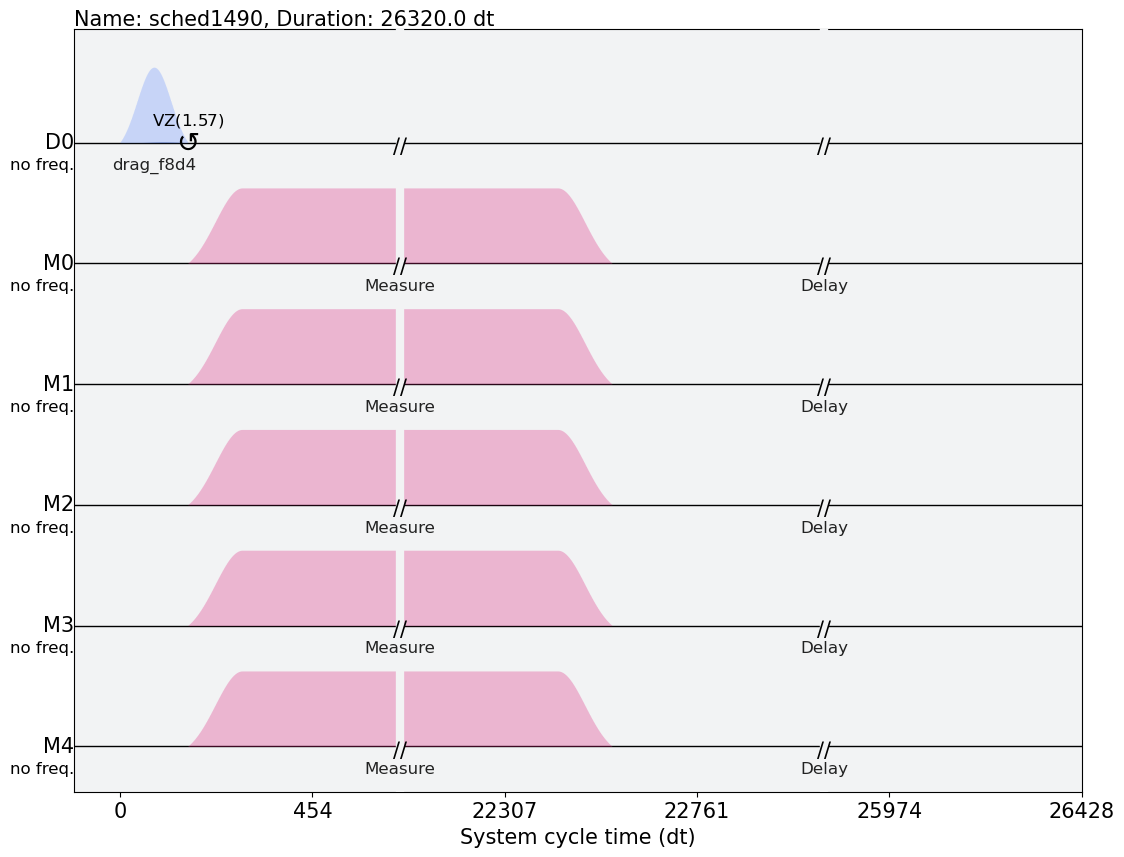

In [130]:
# with pulse.build(backend) as test_sched:
#     pulse.play(pulse.library.Gaussian(200, 1.0, 30), dc(0))
#     pulse.play(pulse.library.Constant(400,0.4),dc(1))

test_sched = pulse.Schedule()

bases = {0:'Y'}
# bases = {0:'Z', 1:'X',2:'Z'}
qc, test_sched = fmeasure(bases,test_sched,backend)
test_sched.draw()

In [131]:
model = PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator()
qobj = assemble(test_sched,
              backend=backend_sim,
              meas_level=2,
              meas_return='single',
              shots=1024)
sim_result = backend_sim.run(qobj, system_model=model).result()
counts = sim_result.get_counts()
counts

C:\Users\Joey\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\pulse\controllers\pulse_controller.py:142: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is beign automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '


{'00000': 1024}

In [82]:
# config.parametric_pulses=[]
inst_sched_map = defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=config.meas_map[0])

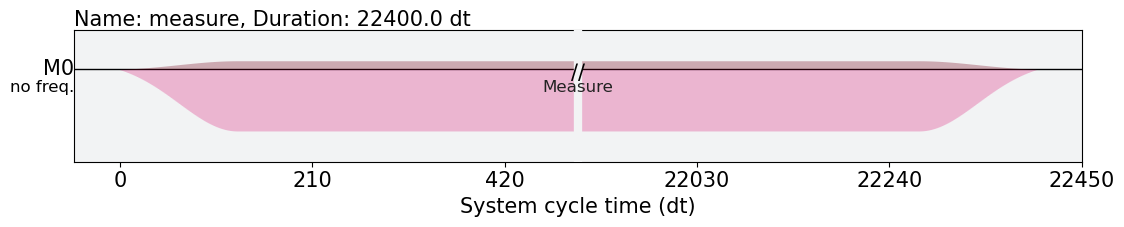

In [83]:
measure.draw()

In [95]:
blah = Schedule()
blah += Play(Gaussian(1000,0.5,50),dc(0))
blah += measure << blah.duration
blah = transforms.add_implicit_acquires(blah, config.meas_map)
blah.instructions

((0, Play(Gaussian(duration=1000, amp=(0.5+0j), sigma=50), DriveChannel(0))),
 (1000, Acquire(22400, AcquireChannel(0), MemorySlot(0))),
 (1000,
  Play(GaussianSquare(duration=22400, amp=(-0.3584733362723958+0.05040701520361846j), sigma=64, width=22144, name='gaussian_square_b937'), MeasureChannel(0), name='gaussian_square_b937')))

In [80]:
blah = Schedule()
blah += Play(Gaussian(1000,0.5,50),dc(0))
blah += Play(Gaussian(1000,0.5,50),dc(0))
# blah |= Play(Gaussian(1000,0.5,50),dc(1))
blah += Acquire(duration=1400, channel=ac(1), mem_slot=MemorySlot(1))

In [96]:
blah.instructions

((0, Play(Gaussian(duration=1000, amp=(0.5+0j), sigma=50), DriveChannel(0))),
 (1000, Acquire(22400, AcquireChannel(0), MemorySlot(0))),
 (1000,
  Play(GaussianSquare(duration=22400, amp=(-0.3584733362723958+0.05040701520361846j), sigma=64, width=22144, name='gaussian_square_b937'), MeasureChannel(0), name='gaussian_square_b937')))

In [ ]:
d = sched.duration
ind = 136 #index of measuring pulse in paris for qubit 7
sched |= Play(SamplePulse(defaults.pulse_library[ind].samples, name=defaults.pulse_library[ind].name), AcquireChannel(qubit)) << d
sched |= Play(SamplePulse(defaults.pulse_library[ind].samples, name=defaults.pulse_library[ind].name), MeasureChannel(qubit)) << d

In [137]:
backend = qiskit.test.mock.FakeValencia()
# backend = qiskit.test.mock.FakeArmonk()
config = backend.configuration()
N = config.n_qubits
bases = {0:'X'}
# bases = {0:'X', 1:'Z'}

# CONVERT ABSTRACT CIRCUIT            
qc = QuantumCircuit(N, N)
for iq in bases:
    if bases[iq]=='X':
        qc.h(iq)
    if bases[iq]=='Y':
        qc.sdg(iq)
        qc.h(iq)
        
for iq in bases:
    qc.measure(iq,iq)
# for iq in range(N):
#     qc.measure(iq,iq)
qc = transpile(qc, backend)
measurements = qiskit.schedule(qc, backend)    
sched = Schedule()
sched = sched.append(measurements)
model = PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator()
qobj = assemble(sched,
              backend=backend_sim,
              meas_level=2,
              meas_return='single',
              shots=1024)
sim_result = backend_sim.run(qobj, system_model=model).result()
counts = sim_result.get_counts()
counts

AttributeError: 'NoneType' object has no attribute 'data'